# Region based Convolutional Neural Network (RCNN) for Object Detection  

The object to be detected is raccoons.  
The images used are 200 images of raccoon with their corresponding annotations (ground truth bounding box).

Steps to perform object detection with RCNN:
1. Create image dataset consisting of 2 classes; each of which contains images of `raccoon` and `no raccoon`
2. Train a classifier (CNN) to classify `raccoon` and `no raccoon`
3. Detect raccoon

The main concept to create image dataset (step 1) and perform object detection using trained classifier (step 3) is using *selective search*. The *selective search* gives (proposes) regions in an image.  

In step 1, these proposed regions are collected to `no raccoon` class if the regions doen't contain raccoon, and to `raccoon` class if the regions contain raccoon.  

In step 3, the *selective search* once again proposes region, creating the region of interests (roi) which are fed as inputs to the classifier, in which the classifier classifies if the regions belong to `raccoon` or `no raccoon`. For a region that is classified as `raccoon`, the bounding box is drawn. At the end, *non maximum suppression* algorithm selects one bounding box out of many overlapping boxes drawn.

This notebook is based on the tutorial from [pyimagesearch](https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/) 

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

In [4]:
images_path = "/content/drive/MyDrive/colab_data/raccoon/images/"
annotations_path = "/content/drive/MyDrive/colab_data/raccoon/annotations/"

## 1 Create dataset with `raccoon` and `no raccoon`

In [5]:
dataset_path = "/content/drive/MyDrive/colab_data/raccoon/dataset/"
positive_path = dataset_path + "raccoon/"
negative_path = dataset_path + "no_raccoon/"

for dirPath in (dataset_path, positive_path, negative_path):
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

In [6]:
def compute_iou(boxA, boxB):
    '''
    calculate intersection over union of two boxes

    Parameters:
      boxA: bounding box 1 coordinates
      boxB: bounding box 2 coordinates
    
    Return:
      iou: intersetion over union
    '''
    # (x, y) of intersection rectangles
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # intersection area
    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # each box area
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = inter_area / float(boxA_area + boxB_area - inter_area)
    return iou

Creating dataset consisting of `raccoon` and `no raccoon`, for an image
- *selective search* proposes 2000 regions (`max_proposals` = 2000)
- save only 30 of 2000 proposed regions that are containing ``raccoon`` whose IOU to ground truth bbox > 0.7, and 10 of 2000 proposed regions that are not containing `raccooon` (`max_positive` = 30; `max_negative` = 10)  

In [7]:
# maximum regions to be proposed by selective search
max_proposals = 2000

# max number of regions containing raccoon and not
max_positive = 30 # max for 
max_negative = 10

# 
total_pos = 0
total_neg = 0

input_dims = (224, 224)

# 
images = glob.glob(images_path + "*.jpg")
n_images = len(images)

# loop over each image
for i, im in enumerate(images):
  print("Processing {} / {} images".format(i + 1, n_images))
  name = im.split("/")[-1].split(".")[-2]
  annotation_file = os.path.sep.join([annotations_path, "{}.xml".format(name)])
  annotation = open(annotation_file).read()
  soup = BeautifulSoup(annotation, "html.parser")
  
  gt_boxes = [] # ground truth boxes for 1 image
  w = int(soup.find("width").string)
  h = int(soup.find("height").string)

  # 1 image may have > 1 gt box
  for o in soup.find_all("object"):
    label = o.find("name").string
    xmin = int(o.find("xmin").string)
    ymin = int(o.find("ymin").string)
    xmax = int(o.find("xmax").string)
    ymax = int(o.find("ymax").string)
    # truncate bounding box if outside of image
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(w, xmax)
    ymax = min(h, ymax)
    gt_boxes.append((xmin, ymin, xmax, ymax))
  
  image = cv2.imread(im)
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()

  proposed_rects= []
  # 1 image has > 1 proposed regions
  for (x, y, w, h) in rects:
    proposed_rects.append((x, y, x + w, y + h))

  pos_roi = 0
  neg_roi = 0

  # loop over each proposed region
  for proposed_rect in proposed_rects[:max_proposals]:
    (prop_startx, prop_starty, prop_endx, prop_endy) = proposed_rect
    # calculate iou of each region to each gt box
    for box in gt_boxes:
      (gt_startx, gt_starty, gt_endx, gt_endy) = box

      iou = compute_iou(box, proposed_rect)
      roi = None
      output_path = None

      # take 30 regions with iou > 0.7 as positive images
      if iou >= 0.7 and pos_roi <= max_positive:
        roi = image[prop_starty: prop_endy, prop_startx: prop_endx]
        filename = "{}.png".format(total_pos)
        output_path = positive_path + filename
        pos_roi += 1
        total_pos += 1

      # check if regions is inside (overlap) the ground truth bbox
      full_overlap = ((prop_startx >= gt_startx) and (prop_starty >= gt_starty) 
      and (prop_endx <= gt_endx) and (prop_endy <= gt_endy))

      # take 10 regions with iou < 0.05 and not overlapping as negative images
      if not full_overlap and iou < 0.05 and neg_roi <= max_negative:
        roi = image[prop_starty: prop_endy, prop_startx: prop_endx]
        filename = "{}.png".format(total_neg)
        output_path = negative_path + filename
        neg_roi += 1
        total_neg += 1

      if roi is not None and output_path is not None:
        roi = cv2.resize(roi, input_dims, interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(output_path, roi)

Processing 1 / 200 images
Processing 2 / 200 images
Processing 3 / 200 images
Processing 4 / 200 images
Processing 5 / 200 images
Processing 6 / 200 images
Processing 7 / 200 images
Processing 8 / 200 images
Processing 9 / 200 images
Processing 10 / 200 images
Processing 11 / 200 images
Processing 12 / 200 images
Processing 13 / 200 images
Processing 14 / 200 images
Processing 15 / 200 images
Processing 16 / 200 images
Processing 17 / 200 images
Processing 18 / 200 images
Processing 19 / 200 images
Processing 20 / 200 images
Processing 21 / 200 images
Processing 22 / 200 images
Processing 23 / 200 images
Processing 24 / 200 images
Processing 25 / 200 images
Processing 26 / 200 images
Processing 27 / 200 images
Processing 28 / 200 images
Processing 29 / 200 images
Processing 30 / 200 images
Processing 31 / 200 images
Processing 32 / 200 images
Processing 33 / 200 images
Processing 34 / 200 images
Processing 35 / 200 images
Processing 36 / 200 images
Processing 37 / 200 images
Processing

## 2 Modeling  
Use transfer learning from `MobileNetV2`

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AvgPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

In [9]:
dataset_path = "/content/drive/MyDrive/colab_data/raccoon/dataset/"

In [10]:
data = []
labels = []

# load raccoon and no raccoon images
for label in os.listdir(dataset_path):
  images = glob.glob(dataset_path + label + "/*.png")
  for image in images:
    image = load_img(image, target_size=input_dims)
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

data.shape

In [11]:
# encoding labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [12]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                    stratify=labels, random_state=42)

# data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [22]:
# hyperparams
lr = 1e-4
n_epochs = 5
batch_size = 32

# pretrained model, freeze the weights
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                       input_tensor=Input(shape=(224, 224, 3)))
for layer in baseModel.layers:
    layer.trainable = False

# add dense layers on top of pretrained network
headModel = baseModel.output
headModel = AvgPool2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
opt = Adam(lr=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

generator = aug.flow(x_train, y_train, batch_size=batch_size)
hist = model.fit(generator, validation_data=(x_test, y_test), epochs=n_epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
94/94 [==============================] - 43s 424ms/step - loss: 0.3286 - accuracy: 0.8901 - val_loss: 0.0654 - val_accuracy: 0.9960
Epoch 2/5
94/94 [==============================] - 39s 417ms/step - loss: 0.0561 - accuracy: 0.9940 - val_loss: 0.0272 - val_accuracy: 0.9960
Epoch 3/5
94/94 [==============================] - 39s 413ms/step - loss: 0.0330 - accuracy: 0.9950 - val_loss: 0.0182 - val_accuracy: 0.9973
Epoch 4/5
94/94 [==============================] - 38s 409ms/step - loss: 0.0191 - accuracy: 0.9963 - val_loss: 0.0136 - val_accuracy: 0.9973
Epoch 5/5
94/94 [==============================] - 39s 410ms/step - loss: 0.0154 - accuracy: 0.9980 - val_loss: 0.0126 - val_accuracy: 0.9973


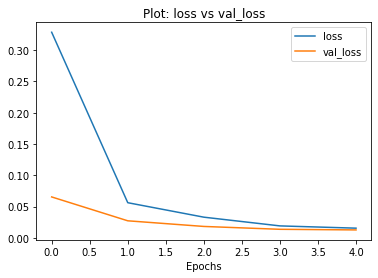

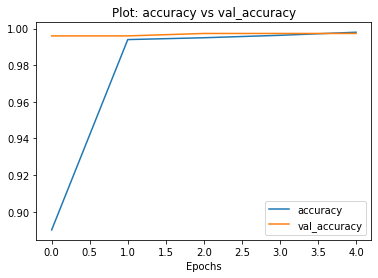

In [23]:
# plot training curve
def plot(hist, param1, param2):
  x_axis = np.arange(0, n_epochs)
  plt.figure()
  plt.plot(x_axis, hist.history[param1], label=param1)
  plt.plot(x_axis, hist.history[param2], label=param2)
  plt.xlabel("Epochs")
  plt.title("Plot: {} vs {}".format(param1, param2))
  plt.legend()
  plt.show()

plot(hist, "loss", "val_loss")
plot(hist, "accuracy", "val_accuracy")

The accuracy on both training and validation are ~99 % with loss values close to 0

In [24]:
# save models and labels
model.save("/content/drive/MyDrive/colab_data/raccoon/raccoon_detector.h5", save_format="h5")

f = open("/content/drive/MyDrive/colab_data/raccoon/label_encoder.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## 3. Detect raccoon

In [25]:
from imutils.object_detection import non_max_suppression

In [26]:
test_image = "/content/drive/MyDrive/colab_data/raccoon/images/raccoon-1.jpg"
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# only take 200 regions proposed from selective search
max_proposals_infer = 200

# take the regions and the box for the regions
proposals = []
boxes = []

for (x, y, w, h) in rects[:max_proposals_infer]:
  roi = image[y: y + h, x: x + w]
  roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  roi = cv2.resize(roi, input_dims, interpolation=cv2.INTER_CUBIC)

  roi = img_to_array(roi)
  roi = preprocess_input(roi)

  proposals.append(roi)
  boxes.append((x, y, x + w, y + h))

proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes)

In [27]:
# predict
predictions = model.predict(proposals)

# class of the regions
class_proposals = lb.classes_[np.argmax(predictions, axis=1)]

# index where regions are classified as raccoon
raccoon_idx = np.where(class_proposals == "raccoon")[0]
# get the box and the predicted value (probability)
boxes = boxes[raccoon_idx]
predictions = predictions[raccoon_idx][:, 1]

# filter out predictions with probability < 0.99
min_proba = 0.99
idxs = np.where(predictions >= min_proba)
boxes = boxes[idxs]
predictions = predictions[idxs]

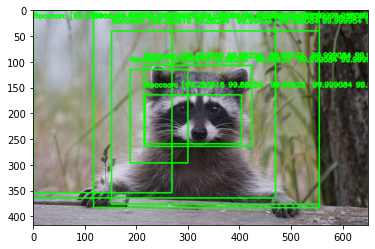

In [28]:
# show the image with all regions classified as raccoon
clone = image.copy()
for (box, pred) in zip(boxes, predictions):
    (start_x, start_y, end_x, end_y) = box
    cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), 
                 (0, 255, 0), 2)
    y = start_y - 15 if start_y - 15 > 15 else start_y + 15
    text = "Raccoon: {}".format(predictions * 100)
    cv2.putText(clone, text, (start_x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
plt.imshow(clone)

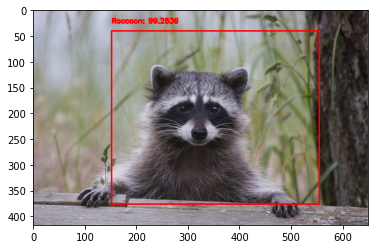

In [29]:
# apply NMS
boxIdxs = non_max_suppression(boxes, predictions)
for i in range(len(boxIdxs)):
    (startX, startY, endX, endY) = boxIdxs[i]
    cv2.rectangle(image, (startX, startY), (endX, endY), 
                 (255, 0, 0), 2)
    y = startY - 15 if startY - 15 > 15 else startY + 15
    text = "Raccoon: {:.4f}".format(predictions[i] * 100)
    cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
               0.45, (255, 0, 0), 2)
plt.imshow(image)
plt.show()

###  Misc.

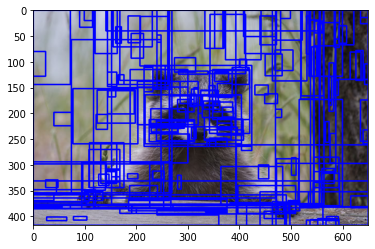

In [32]:
test_image = "/content/drive/MyDrive/colab_data/raccoon/images/raccoon-1.jpg"
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
copy = image.copy()
for (x, y, w, h) in rects[:max_proposals_infer]:
  cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
plt.imshow(copy)